# Сегментация пользователей мобильного приложения на основе поведения.

## Краткое описание проекта

**Описание проекта:**
Для анализа представлены данные о событиях, совершенных в мобильном приложении
"Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая
их на доске объявлений. В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года. 

**Цель исследования:**
Данное исследование позволит выявить наиболее "ценные" сегменты среди пользователей, основываясь на их поведения в мобильном приложении.

**В результатах данного проекта заинтересованы:**
- владельцы и управляющие данного мобильного приложения (для принятия решения по распределению маркетингового бюджета и повышению эффективности привлечения пользователей из разных источников),
- маркетологи (для более точного описания целевой аудитории и выявления наиболее ценной аудитории, разработка и проведение эффективных рекламных компания).

**На основе проведенного анализа могут быть приняты следующие решения:**
- корректировка рекламного бюджета, исходя из эффективности разных каналов привлечения;
- развитие системы персонализации для повышение вовлеченности пользователей (индивидуальны подборки, уведомления о скидках, рекомендации на основе поведения).

**Ход исследования:**
1. Загрузка и предобработка данных:
    - Загрузка датафреймов;
    - Изучение предоставленных данных на наличие пропусков, дубликатов, соответствие типам данных;
    - Объединение исходных массивов в один датафрейм, проверка корректности объединения, удаление дублирующих столбцов данных;
    - Проверка массива на явные/неявные дубликаты, при необходимости очистка от них;
    - Корректировка типа данных (для формата времени);
    - Категоризация данных (при необходимости).
2. Исследовательский анализ:
    - Расчет и визуализация метрики "retention rate" для всех пользователей.
    - Анализ времени, которое пользователи проводят в приложении:
        - расчет среднего и медианного времени,
        - логирование сессии,
        - описание аномалий и "выбросов",
    - Анализ частоты действий пользователей:
        - описание основных событий,
        - анализ зависимости частоты действий от дней недели, времени суток,
        - формирование рекомендаций по сегментации пользователей.
    - Расчет конверсии в целевое действие (просмотр контактов) для всех пользователей.
3. Сегментация пользователей:
    - Описание "полезности" выбранной сегментации.
    - Анализ сегментов пользователей по retention rate.
    - Анализ сегментов пользователей по конверсии в целевой действие.
4. Проверка статистических гипотез:
    - Гипотеза 1: группы пользователей, из разных каналов привлечения (Yandex или Google) демонстрируют разную конверсию в просмотры контактов.
        - H₀: Конверсия в целевое действие (просмотр контактов) не различается у пользователей обеих групп.
        - H₁: Конверсия различается.
    - Гипотеза 2: добавление объявлений в избранное влияет на конверсию в просмотры контактов.
        - H₀: Конверсия в целевое действие (просмотр контактов) не различается у пользователей обеих групп (тех, кто добавил в "избранное" и тех, кто нет).
        - H₁: Конверсия различается. 
5. Общие выводы и рекомендации на основе проведенного анализа.

## Загрузка и предобработка данных

In [1]:
import os
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math as mth
import scipy.stats as st

### Датасет с действиями пользователей (`mobile_dataset`)

Преобразуем в относительный путь относительно текущей директории и загрузим датасет:

In [2]:
absolute_path_1 = '/datasets/mobile_dataset.csv'

relative_path_1 = os.path.relpath(absolute_path_1)

pth1_1 = 'https://code.s3.yandex.net/datasets/mobile_dataset.csv'
pth1_2 = relative_path_1

# Функция для проверки, доступен ли URL
def url_exists(url):
    try:
        response = requests.head(url)
        return response.status_code == 200
    except:
        return False

# Проверяем наличие файла
if os.path.exists(pth1_2):  
    query1_1 = pd.read_csv(pth1_2)
    print("Файл загружен локально")
elif url_exists(pth1_1):  
    query1_1 = pd.read_csv(pth1_1)
    print("Файл загружен с URL")
else:
    print("Ошибка: Файл не найден ни локально, ни по URL")

Файл загружен локально


In [3]:
dataset = query1_1
dataset.head(3)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Названия столбцов необходимо перевести в "snake_case":

In [4]:
dataset.columns = [x.replace('.', '_') for x in dataset.columns.values]

Проверим на наличие пустых значений, а также явных и не явных дубликатов:

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
dataset.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [7]:
dataset.duplicated().sum()

0

In [8]:
dataset[dataset.duplicated(['event_time',
                            'event_name',
                            'user_id'])].count()

event_time    0
event_name    0
user_id       0
dtype: int64

Пустые значения отсутствуют. Явные и неявные дубликаты не выявлены.

Изменим формат данных для столбца со временем совершения действий на корректный: 

In [9]:
dataset['event_time'] = pd.to_datetime(dataset['event_time'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [10]:
start_date = dataset['event_time'].dt.date.min()
end_date = dataset['event_time'].dt.date.max()
print(f'Датасет содержит данные от {start_date.strftime("%d.%m.%y")} до {end_date.strftime("%d.%m.%y")}.')


Датасет содержит данные от 07.10.19 до 03.11.19.


Рассмотрим существующие виды действий: 

In [11]:
dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

- Действия `contacts_show` и `show_contacts` обозначают одно и то же - `посмотрел номер телефона`.
- Действия `search_1 — search_7` — это разные действия, связанные с `поиском по сайту`, но так как они не детализированы для дальнейшего анализа можем объединить их в одну группу.
- Скорректируем виды действий пользователей: 

In [12]:
dataset['event_name'] = dataset['event_name'].replace({
    'show_contacts': 'contacts_show',
    'search_1': 'search',
    'search_2': 'search',
    'search_3': 'search',
    'search_4': 'search',
    'search_5': 'search',
    'search_6': 'search',
    'search_7': 'search',
})

In [13]:
dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

**Вывод по датасету `mobile_dataset`:**
- содержит 74197 наблюдений,
- описывает 3 атрибута (время совершения действия, идентификатор пользователя, наименование действия пользователя),
- период исследования: 07 октября - 03 ноября 2019 года.
- наименование столбцов приведено к snake_case,
- пропусков в данных нет,
- явные и неявные дубликаты не выявлены,
- формат данных времени переведен в `datetime64[ns]`,
- миллисекунды в данных о времени совершения действия оставлены, чтобы избежать дублирования событий при дальнейшем анализе. 
- 7 неопределенных видов `search` объединены в один вид действия, также дублирующие действия `contacts_show` и `show_contacts` объединены в один вид действия.

### Датасет с источниками установки приложения (`mobile_sources`)

Преобразуем в относительный путь относительно текущей директории и загрузим датасет:

In [14]:
absolute_path_2 = '/datasets/mobile_sources.csv'

relative_path_2 = os.path.relpath(absolute_path_2)

pth2_1 = 'https://code.s3.yandex.net/datasets/mobile_sourсes.csv'
pth2_2 = relative_path_2

# Функция для проверки, доступен ли URL
def url_exists(url):
    try:
        response = requests.head(url)
        return response.status_code == 200
    except:
        return False

# Проверяем наличие файла
if os.path.exists(pth2_2):  
    query2_1 = pd.read_csv(pth2_2)
    print("Файл загружен локально")
elif url_exists(pth2_1):  
    query2_1 = pd.read_csv(pth2_1)
    print("Файл загружен с URL")
else:
    print("Ошибка: Файл не найден ни локально, ни по URL")

Файл загружен локально


In [15]:
sources = query2_1
sources.head(3)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex


Названия столбцов необходимо перевести в "snake_case":

In [16]:
sources = sources.rename(columns={'userId': 'user_id'})

Проверим на наличие пустых значений, а также явных и не явных дубликатов:

In [17]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [18]:
sources.isna().sum()

user_id    0
source     0
dtype: int64

In [19]:
sources.duplicated().sum()

0

In [20]:
sources[sources.duplicated(['source',
                            'user_id'])].count()

user_id    0
source     0
dtype: int64

Пустые значения отсутствуют. Явные и неявные дубликаты не выявлены.

Рассмотрим существующие виды источников, с которых пользователи установил приложение: 

In [21]:
sources['source'].value_counts()

yandex    1934
other     1230
google    1129
Name: source, dtype: int64

**Вывод по датасету `mobile_sources`:**
- содержит 4293 наблюдения,
- описывает 2 атрибута (идентификатор пользователя;  источник, с которого пользователь установил приложение),
- наименование столбцов приведено к snake_case,
- пропусков в данных нет,
- явные и неявные дубликаты не выявлены.

### Создадим единый датасет:

Исследуемые датасеты содержат идентичные атрибуты (идентификатор пользователя), поэтому могут быть объединены для дальнейшего анализа.

In [22]:
df = dataset.merge(sources, on='user_id', how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


Проверим успешность объединения:

In [23]:
if dataset.shape[0] == df.shape[0] and (df['source'].isna().sum())==0:
    print('Объединение прошло успешно и у всех пользователей указан канал привлечения.')
else:
    print('Что-то пошло не так.')

Объединение прошло успешно и у всех пользователей указан канал привлечения.


### Вывод по предобработке данных:

- Для анализа представлены данные:
    - за период с 7 октября по 3 ноября 2019 года:
    - 74197 действий в мобильном приложении, следующих видов:
        - advert_open (открыл карточки объявления),
        - photos_show (просмотрел фотографий в объявлении),
        - tips_show (увидел рекомендованные объявления),
        - tips_click (кликнул по рекомендованному объявлению),
        - contacts_show/show_contacts (посмотрел номер телефона),
        - contacts_call (позвонил по номеру из объявления),
        - map (открыл карту объявлений),
        - search_1 — search_7 (разные действия, связанные с поиском по сайту),
        - favorites_add (добавил объявление в избранное).
    - 3 вида источников:
        - yandex,
        - google,
        - other.
    - 4293 уникальных пользователя.
- Данные не содержат пропусков, явных и неявных дубликатов не выявлено.
- Форматы данных корректные.
- Исходные массивы объединены в единый датасет  по идентификатору пользователя для дальнейшего анализа.

## Исследовательский анализ

### Удержание пользователей (retention rate)

Создадим новый датасет с датами первых посещений каждым пользователем по дням:

In [24]:
first_visit_df = df.groupby('user_id')\
                   .agg({'event_time': 'min'})\
                   .reset_index()\
                   .rename(columns={'event_time': 'first_day_visit'})

first_visit_df['first_day_visit'] = first_visit_df['first_day_visit'].dt.floor('D')

first_visit_df.head(3)

,user_id,first_day_visit
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01


Добавим данные о первом дне активности в приложении в осной датасет:

In [25]:
df = df.merge(first_visit_df, 
              on='user_id', 
              how='left')

df.head(3)

,event_time,event_name,user_id,source,first_day_visit
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07


Вычислим `lifetime`: 

In [26]:
df['lifetime'] = (df['event_time'] - df['first_day_visit']).dt.days

df['lifetime'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

Построим таблицу удержания:

In [27]:
retention_table = df.pivot_table(
    index='first_day_visit',
    columns='lifetime',
    values='user_id',
    aggfunc='nunique'
)

retention_table

lifetime,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,204.0,37.0,21.0,22.0,14.0,12.0,8.0,16.0,13.0,10.0,...,6.0,8.0,2.0,4.0,8.0,6.0,4.0,10.0,4.0,3.0
2019-10-08,167.0,30.0,20.0,17.0,6.0,6.0,11.0,8.0,11.0,9.0,...,2.0,6.0,8.0,3.0,4.0,6.0,5.0,5.0,5.0,NaN
2019-10-09,176.0,17.0,15.0,10.0,10.0,14.0,10.0,10.0,10.0,9.0,...,2.0,5.0,3.0,2.0,5.0,1.0,3.0,5.0,NaN,NaN
2019-10-10,174.0,24.0,13.0,18.0,13.0,16.0,11.0,13.0,11.0,10.0,...,7.0,5.0,3.0,6.0,4.0,3.0,3.0,NaN,NaN,NaN
2019-10-11,136.0,12.0,11.0,18.0,13.0,9.0,8.0,10.0,3.0,NaN,...,5.0,4.0,4.0,4.0,3.0,3.0,NaN,NaN,NaN,NaN
2019-10-12,125.0,25.0,15.0,13.0,8.0,9.0,13.0,10.0,9.0,8.0,...,5.0,4.0,2.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2019-10-13,148.0,26.0,13.0,8.0,11.0,9.0,6.0,12.0,7.0,9.0,...,4.0,3.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-14,185.0,31.0,17.0,18.0,19.0,13.0,10.0,10.0,10.0,10.0,...,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-15,186.0,28.0,19.0,17.0,11.0,10.0,12.0,13.0,16.0,6.0,...,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Расчитаем размер когорт:

In [28]:
cohort_sizes = df.groupby('first_day_visit')\
                 .agg({'user_id': 'nunique'})\
                 .rename(columns={'user_id': 'cohort_size'})

cohort_sizes.style.background_gradient(cmap='PuBu')

,cohort_size
first_day_visit,
2019-10-07 00:00:00,204
2019-10-08 00:00:00,167
2019-10-09 00:00:00,176
2019-10-10 00:00:00,174
2019-10-11 00:00:00,136
2019-10-12 00:00:00,125
2019-10-13 00:00:00,148
2019-10-14 00:00:00,185
2019-10-15 00:00:00,186


In [29]:
cohort_sizes.describe()

,cohort_size
count,28.000000
mean,153.321429
std,24.141640
min,97.000000
25%,135.750000
50%,156.500000
75%,167.750000
max,204.000000


Объеденим размеры когорт и таблицу удержания:

In [30]:
retention_table_curr = cohort_sizes.merge(retention_table,
                                          on='first_day_visit',
                                          how='left').fillna(0)

retention_table_curr

,cohort_size,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,204,204.0,37.0,21.0,22.0,14.0,12.0,8.0,16.0,13.0,...,6.0,8.0,2.0,4.0,8.0,6.0,4.0,10.0,4.0,3.0
2019-10-08,167,167.0,30.0,20.0,17.0,6.0,6.0,11.0,8.0,11.0,...,2.0,6.0,8.0,3.0,4.0,6.0,5.0,5.0,5.0,0.0
2019-10-09,176,176.0,17.0,15.0,10.0,10.0,14.0,10.0,10.0,10.0,...,2.0,5.0,3.0,2.0,5.0,1.0,3.0,5.0,0.0,0.0
2019-10-10,174,174.0,24.0,13.0,18.0,13.0,16.0,11.0,13.0,11.0,...,7.0,5.0,3.0,6.0,4.0,3.0,3.0,0.0,0.0,0.0
2019-10-11,136,136.0,12.0,11.0,18.0,13.0,9.0,8.0,10.0,3.0,...,5.0,4.0,4.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0
2019-10-12,125,125.0,25.0,15.0,13.0,8.0,9.0,13.0,10.0,9.0,...,5.0,4.0,2.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0
2019-10-13,148,148.0,26.0,13.0,8.0,11.0,9.0,6.0,12.0,7.0,...,4.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14,185,185.0,31.0,17.0,18.0,19.0,13.0,10.0,10.0,10.0,...,5.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-15,186,186.0,28.0,19.0,17.0,11.0,10.0,12.0,13.0,16.0,...,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Расчитаем `retention rate` (в виде долей от 0 до 1):

In [31]:
retention_rate = retention_table_curr.div(
    retention_table_curr['cohort_size'], 
    axis=0
)

retention_rate.drop(columns=['cohort_size'],
                    inplace=True)

retention_rate

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,1.0,0.181373,0.102941,0.107843,0.068627,0.058824,0.039216,0.078431,0.063725,0.049020,...,0.029412,0.039216,0.009804,0.019608,0.039216,0.029412,0.019608,0.049020,0.019608,0.014706
2019-10-08,1.0,0.179641,0.119760,0.101796,0.035928,0.035928,0.065868,0.047904,0.065868,0.053892,...,0.011976,0.035928,0.047904,0.017964,0.023952,0.035928,0.029940,0.029940,0.029940,0.000000
2019-10-09,1.0,0.096591,0.085227,0.056818,0.056818,0.079545,0.056818,0.056818,0.056818,0.051136,...,0.011364,0.028409,0.017045,0.011364,0.028409,0.005682,0.017045,0.028409,0.000000,0.000000
2019-10-10,1.0,0.137931,0.074713,0.103448,0.074713,0.091954,0.063218,0.074713,0.063218,0.057471,...,0.040230,0.028736,0.017241,0.034483,0.022989,0.017241,0.017241,0.000000,0.000000,0.000000
2019-10-11,1.0,0.088235,0.080882,0.132353,0.095588,0.066176,0.058824,0.073529,0.022059,0.000000,...,0.036765,0.029412,0.029412,0.029412,0.022059,0.022059,0.000000,0.000000,0.000000,0.000000
2019-10-12,1.0,0.200000,0.120000,0.104000,0.064000,0.072000,0.104000,0.080000,0.072000,0.064000,...,0.040000,0.032000,0.016000,0.056000,0.056000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-13,1.0,0.175676,0.087838,0.054054,0.074324,0.060811,0.040541,0.081081,0.047297,0.060811,...,0.027027,0.020270,0.006757,0.033784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-14,1.0,0.167568,0.091892,0.097297,0.102703,0.070270,0.054054,0.054054,0.054054,0.054054,...,0.027027,0.005405,0.021622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-15,1.0,0.150538,0.102151,0.091398,0.059140,0.053763,0.064516,0.069892,0.086022,0.032258,...,0.026882,0.021505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Визуализируем полученный табличный результат удержания пользователей с помощью `heatmap`:

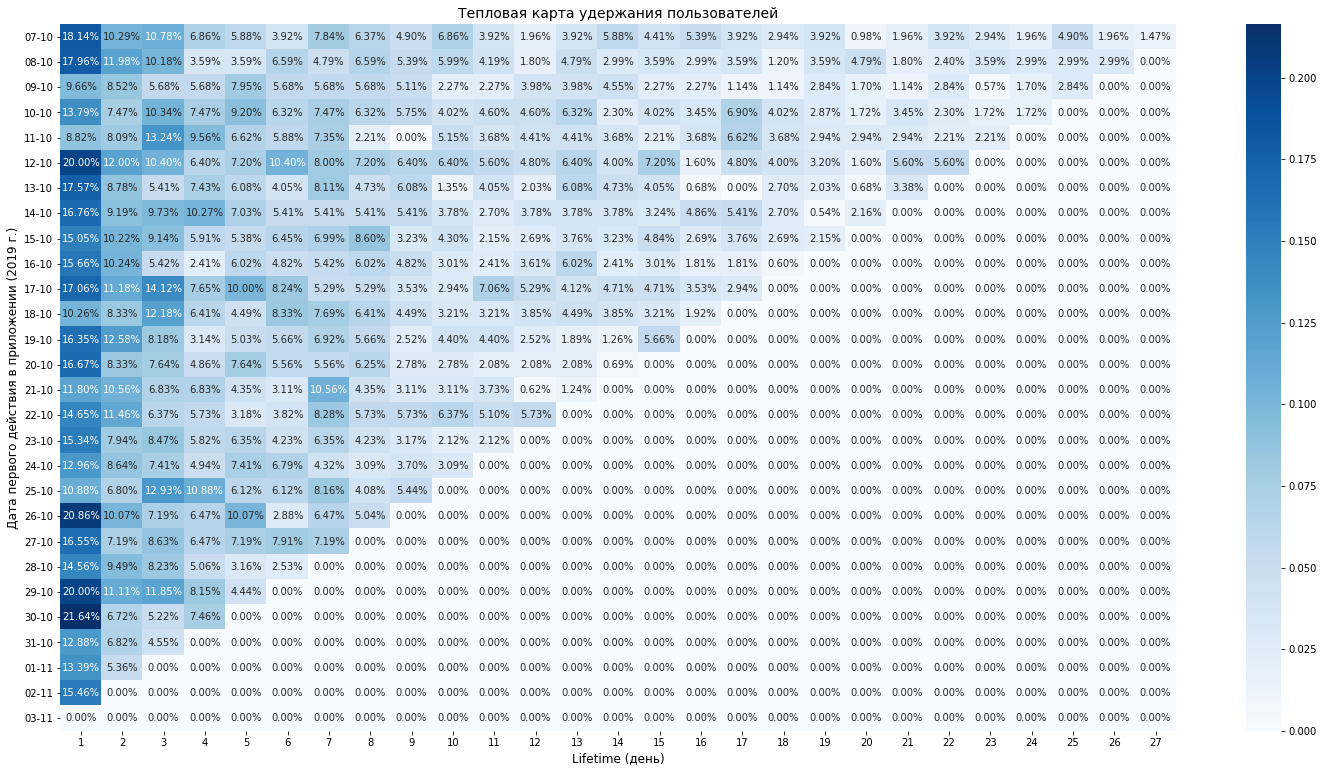

In [32]:
plt.figure(figsize=(20,10))
ax=sns.heatmap(
    retention_rate.drop(columns=[0]),
    annot=True,
    fmt='.2%',
    cmap='Blues'
)

ticklabels = [retention_rate.index[int(tick)]\
              .strftime('%d-%m') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels)

ax.figure.set_size_inches(25,13)
plt.title('Тепловая карта удержания пользователей', fontsize=14)
plt.xlabel('Lifetime (день)', fontsize=12)
plt.ylabel('Дата первого действия в приложении (2019 г.)', fontsize=12)

plt.show();

#### Вывод по удержанию пользователей (retention rate):
- В среднем размер ежедневной когорты составляет 153 пользователя (колеблется от 97 до 204 пользователей). Большинство значений когорты приближено к 157 пользователей. Значительное количество пользователей было зафиксировано в приложении в субботы 12 и 26 октября, а также 29-30 октября (вторник - среда).
- В целом, удержание пользователей не дольше 1-3 дней, при этом уже на второй день происходит довольно резкое снижение удержания, а к 7-10 дню становится незначительным:
    - наименьшая динамика снижения у когорт 7-8 октября,
    - "обвал" взаимодействия почти в два раза у пользователей 26, 29-30 октября. 
- Резкое увеличение количества привлеченных пользователей в 1-ый день может быть связано с активной маркетинговой/рекламной кампанией или сезонностью.
- Низкий уровень удержания может быть вызван двумя противоположными явлениями:
    - с одной стороны, пользователь может "закрыть свою задачу" максимально быстро, используя данное приложение и поэтому не использовать его продолжительное время;
    - с другой стороны, возможна обратная ситуация, при которой пользователь не нашел, то что ему нужно в первые 1-2 дня использования приложения и перестал им пользоваться.

### Пользовательская вовлеченность

Для описания поведения пользователей, выявления степени их активности в приложении и вовлеченности, проанализируем время проведенное пользователями в приложении. Рассмотрим данную задаче сквозь призму сессий (пользовательский сеанс, время посещения приложения без значительных перерывов во времени), а также среднее и медианное время в приложении.

#### Количество сессий

In [33]:
df = df.sort_values(['user_id', 'event_time'])\
       .reset_index(drop=True)

df.head(3)

,event_time,event_name,user_id,source,first_day_visit,lifetime
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0


Для задания границ сессий определим время периода бездействия, который превышает 30 минут. Определим, когда прошло больше 30 минут между действиями пользователя:

In [34]:
df['session_break'] = df.groupby('user_id')['event_time'].diff()\
                        > pd.Timedelta('30Min')

df.head(3)

,event_time,event_name,user_id,source,first_day_visit,lifetime,session_break
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0,False
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0,False
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0,False


Сгенерируем идентификатор для каждой сессии, который увеличивается если бездействие в приложении превышает 30 минут:

In [35]:
df['session_id'] = df.groupby('user_id')['session_break'].cumsum()

df.head(3)

,event_time,event_name,user_id,source,first_day_visit,lifetime,session_break,session_id
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0,False,0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0,False,0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0,False,0


Рассчитаем общее количество сессии на каждого пользователя:

In [36]:
user_sessions = df.groupby('user_id')\
                  .agg({'session_id': 'nunique'})\
                  .rename(columns={'session_id': 'total_sessions'})

total_sessions = user_sessions['total_sessions']
total_sessions.describe()

count    4293.000000
mean        2.415094
std         3.536466
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        99.000000
Name: total_sessions, dtype: float64

Описательные статистики показывают, что большинство пользователей совершают от 1 до 3 сессий в приложении. По исходным данным (без учета аномалий и "выбросов") пользователь в среднем совершает 2 сессии в приложении. Однако, максимальное значение составляет 99 сессий, что является очевидной аномалий, которая влияет на показатель среднего. При этом, медианное значение, менее зависимое от выбросов, составляет 1 сессию на пользователя. Визуализируем выбросы с помощью диаграммы размаха: 

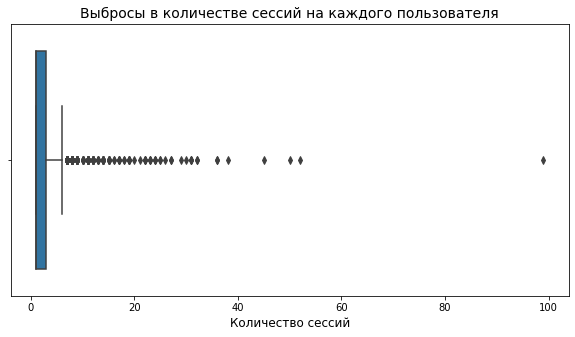

In [37]:
plt.figure(figsize=(10,5))
sns.boxplot(x=total_sessions)
plt.title('Выбросы в количестве сессий на каждого пользователя', fontsize=14)
plt.xlabel('Количество сессий', fontsize=12)
plt.show();

Проанализируем группу "аномальных" пользователей. Установим границы выбросов, при этом, нижняя граница не может быть меньше 0, т.к. количество сессий не может быть отрицательным: 

In [38]:
q1_total_sessions = total_sessions.quantile(0.25)
q3_total_sessions = total_sessions.quantile(0.75)
iqr_total_sessions = q3_total_sessions - q1_total_sessions

lower_bound_total_sessions = max(0, q1_total_sessions - 1.5 * iqr_total_sessions)
upper_bound_total_sessions = round(q3_total_sessions + 1.5 * iqr_total_sessions)

print(f'{upper_bound_total_sessions} сессий одного пользователя является верхней границей нормы.')

6 сессий одного пользователя является верхней границей нормы.


Рассчитаем долю "аномальных" пользователей, чтобы оценить возможные потери при дальнейшем анализе в случае их удаления из массива:  

In [39]:
outliers_total_sessions = user_sessions[(total_sessions < lower_bound_total_sessions) | (total_sessions > upper_bound_total_sessions)]

print(f'В исходном массиве обнаружено {len(outliers_total_sessions)} аномальных пользователей с большим количество сессий ({round(len(outliers_total_sessions) / len(user_sessions) *100, 2)}% всего массива).')

В исходном массиве обнаружено 228 аномальных пользователей с большим количество сессий (5.31% всего массива).


Построим гистограмму распределения количества сессий на каждого пользователя, при этом исключим выбросы:

In [40]:
normal_df = df[~df['user_id'].isin(outliers_total_sessions.index)]
normal_user_sessions = normal_df.groupby('user_id')\
                  .agg({'session_id': 'nunique'})\
                  .rename(columns={'session_id': 'total_sessions'})

normal_total_sessions = normal_user_sessions['total_sessions']
normal_total_sessions.describe()

count    4065.000000
mean        1.821648
std         1.194815
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: total_sessions, dtype: float64

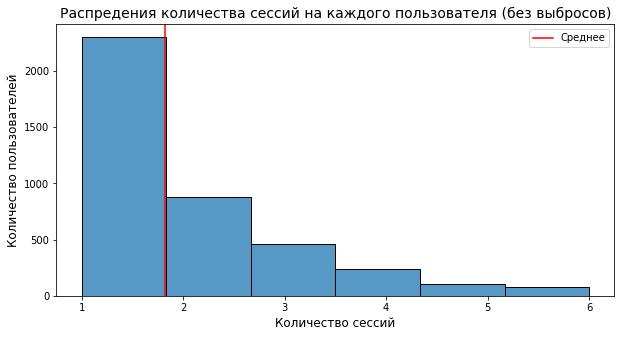

In [41]:
plt.figure(figsize=(10,5))
sns.histplot(normal_user_sessions,
            bins=6)
plt.axvline(normal_total_sessions.mean(), color='red', label='Среднее')
plt.title('Распредения количества сессий на каждого пользователя (без выбросов)', fontsize=14)
plt.xlabel('Количество сессий', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.legend()
plt.show();

##### Вывод по количеству сессий:
- Большинство пользователей совершают 1-3 сессии. 
- Среднее количество сессий при анализе исходного массива данных составляет 2,4 сессии на одного пользователя, при исключении выбросов из анализа, среднее значение - 1,8 сессии на одного пользователя. Медианное значение (менее зависимое от выбросов) составляет 1 сессию на 1 пользователя.
- Верхней границей нормы активности является 6 сессий. За пределами этой границы находятся примерно 5% пользователей (228 человек) с аномальной активностью, доходящие до 99 сессий. Данная группа, несмотря на свой небольшой размер. может быть интересна для более глубокого анализа, поскольку может представлять лояльную и наиболее вовлеченную аудиторию. Однако, стоит отметить, что данное поведение может быть искусственно создано (например, ботами).
- Таким образом, поведение большинства пользователей характеризуется низкой активностью. Небольшое количество сессий указывает на краткосрочное взаимодействие с приложением.

#### Время каждой сессии

Опишем основные статистики времени каждой сессии: 

In [42]:
session_time = df.groupby(['user_id', 'session_id'])\
                 .agg(start=('event_time', 'min'),
                      end=('event_time', 'max'))\
                 .reset_index() 
session_time['session_duration'] = (session_time['end'] - session_time['start']).dt\
                                                                                .total_seconds()\
                                                                                .round(0)
session_duration = session_time['session_duration']
session_duration.describe()

count    10368.000000
mean       772.668113
std       1191.614695
min          0.000000
25%         21.000000
50%        335.000000
75%       1045.250000
max      19318.000000
Name: session_duration, dtype: float64

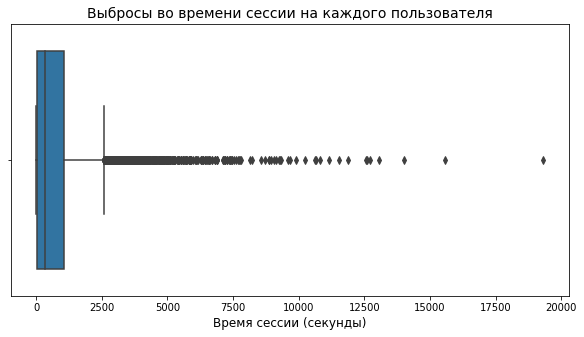

In [43]:
plt.figure(figsize=(10,5))
sns.boxplot(x=session_duration)
plt.title('Выбросы во времени сессии на каждого пользователя', fontsize=14)
plt.xlabel('Время сессии (секунды)', fontsize=12)
plt.show();

In [44]:
q1_session_duration = session_duration.quantile(0.25)
q3_session_duration = session_duration.quantile(0.75)
iqr_session_duration = q3_session_duration - q1_session_duration

upper_bound_session_duration = round(q3_session_duration + 1.5 * iqr_session_duration)

print(f'Сессии, длительностью более {upper_bound_session_duration} секунд (примерно {round(upper_bound_session_duration/60)} минуты), можно считать выбросами.')

Сессии, длительностью более 2582 секунд (примерно 43 минуты), можно считать выбросами.


In [45]:
outliers_session_duration = session_time[(session_duration > upper_bound_session_duration)]

print(f'Обнаружено {len(outliers_session_duration)} аномально долгих сессий '
      f'({round(len(outliers_session_duration) / len(session_time) * 100, 2)}% всеx сессий).')

Обнаружено 682 аномально долгих сессий (6.58% всеx сессий).


Опишем статистики времени сессий без выбросов, чтобы показатель среднего был корректным:

In [46]:
normal_session_time = session_time[session_time['session_duration'] <= upper_bound_session_duration]

normal_session_time['session_duration'].describe()

count    9686.000000
mean      533.855461
std       632.273080
min         0.000000
25%        10.000000
50%       282.000000
75%       839.750000
max      2582.000000
Name: session_duration, dtype: float64

Анализ коротких сессий (0 секунд)

In [47]:
short_sessions = session_time[session_time['session_duration'] == 0]['session_id'].unique()
print(f'Количество "нулевых" сессий: {len(short_sessions)} (из {len(user_sessions)} сессий.)')

Количество "нулевых" сессий: 67 (из 4293 сессий.)


Рассмотрим, какие события происходили в этих сессиях:

In [48]:
df[df['session_id'].isin(short_sessions)]['event_name'].value_counts()

tips_show        39904
photos_show      10009
search            6779
advert_open       6156
contacts_show     4513
map               3875
favorites_add     1416
tips_click         812
contacts_call      541
Name: event_name, dtype: int64

Так как основные события "увидел рекомендованные объявления" (`tips_show`) и "просмотрел фотографий в объявлении" (`photos_show`), это может  аномалия или ошибка, но скорее всего, это "быстрое взаимодействие с приложением".

##### Вывод по времени сессий:
- При анализе исходного массива была установлена верхняя граница нормы времени одной сессии, которое составляет примерно 43 минуты (2582 сек.). За пределы данного показателя выходят 6,6% сессий (682 шт.). Аномальные сессии могут достигать примерно 5,5 часов, но такой случай единичен.
- Показатель среднего времени 1 сессии (на основе исходных данным) составляет  примерно 13 минут, при этом, данный показатель снижается примерно до 9-минутной сессии в среднем, если не учитываются аномально длинные сессии.
- Медианная длительность сессии составляет около 5,5 минут (335 сек.). При этом, если не включать в анализ аномально длинные сессии, типичная длительность одной сессии составит примерно 4,7 минуты (282 сек.). 
- "Нулевые" сессии содержат в большей степени просмотр рекомендаций и просмотр фото в объявлении, что может говорит о нескольких вариантах поведения пользователя:
        - пассивное потребление контента (без активных действий) и возможно, что пользователь не ищет целенаправленно что-то в приложении,
        - пользователь не находит нужной информации и поэтому сразу покидает приложение.
- Аномальные значения оставлены в анализе, так как могут представлять интерес для изучения наиболее вовлеченных пользователей. При этом, следует отметить, что в основном пользователь приложения имеет низкую вовлеченность.

#### Выводы по пользовательской вовлеченности:
- В целом, пользовательская вовлеченность в приложение низкая. Это проявляется как в небольшом количестве сессий, так и во недолгом времени сессий.
- Основной сценарий использования приложения - краткосрочное или одноразовое использование.

### Пользовательская активность (частота событий)

#### Общая структура видов событий

Рассчитаем распределение видов событий:

In [49]:
events = df['event_name'].value_counts()\
                         .reset_index()\
                         .rename(columns={'index': 'event_name',
                                          'event_name': 'event_count'}
                                      )
events['shape_of_events'] = (events['event_count']/events['event_count'].sum())\
                            .map("{:.0%}".format)
events

,event_name,event_count,shape_of_events
0,tips_show,40055,54%
1,photos_show,10012,13%
2,search,6784,9%
3,advert_open,6164,8%
4,contacts_show,4529,6%
5,map,3881,5%
6,favorites_add,1417,2%
7,tips_click,814,1%
8,contacts_call,541,1%


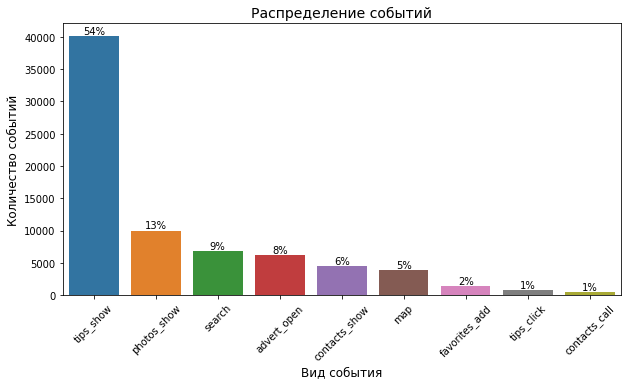

In [50]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='event_name', 
                 y='event_count', 
                 data=events)

for bar, percentage in zip(ax.patches, events['shape_of_events']):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,
        f'{percentage}', 
        ha='center', 
        va='bottom', 
        fontsize=10
    )
    
plt.title('Распределение событий', fontsize=14)
plt.xlabel('Вид события', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(rotation=45)
plt.show();

- Показ рекомендованных объявлений является лидирующим видом событий (54% всех действий в приложении), при этом кликают по рекомендациям только в 1% от всех действий. 
- Пользователи часто просматривают фото объявлений (13% действий в приложении).
- Поиск объявлений составляет 9% от всех действий, а открытие конкретных объявлений происходит только в 8% действий и только 2% действий в приложении связаны с добавлением объявление в "избранное".
- 6% всех событий относится к просмотру контактов и 5% к просмотру карты.
- Также меньше всего пользователи переходят к звонку (только 1% действий). 

Расчитаем количество уникальных пользователей для каждого события:

In [51]:
users_per_event = df.groupby('event_name')['user_id']\
                    .nunique()\
                    .reset_index()\
                    .sort_values(by='user_id', ascending=False)\
                    .rename(columns={'user_id': 'users_count'})

users_per_event['shape_of_users'] = (users_per_event['users_count']/users_per_event['users_count'].sum())\
                                    .map("{:.0%}".format)

users_per_event

,event_name,users_count,shape_of_users
8,tips_show,2801,29%
6,search,1666,17%
4,map,1456,15%
5,photos_show,1095,11%
2,contacts_show,981,10%
0,advert_open,751,8%
3,favorites_add,351,4%
7,tips_click,322,3%
1,contacts_call,213,2%


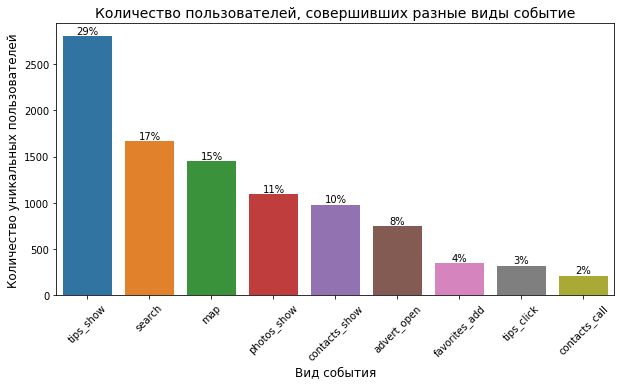

In [52]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='event_name', 
                 y='users_count', 
                 data=users_per_event)

for bar, percentage in zip(ax.patches, users_per_event['shape_of_users']):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,
        f'{percentage}', 
        ha='center', 
        va='bottom', 
        fontsize=10
    )
    
plt.title('Количество пользователей, совершивших разные виды событие', fontsize=14)
plt.xlabel('Вид события', fontsize=12)
plt.ylabel('Количество уникальных пользователей', fontsize=12)
plt.xticks(rotation=45)
plt.show();

- Чуть меньше трети (29%) всех пользователей просматривает рекомендованные объявления. 
- Заметное вовлечение пользователей в поисковые действия. Активное использование поиска (объединенная группа видов действий) выявлено у 17% пользователей, а 15% пользователей просматривали карту объявлений.
- Почти каждый десятый пользователь (11%) интересуются деталями объявления.
- Доля пользователей, заинтересованая в контактах в объявлении, составляет 10% от всех пользователей.
- Открывают карточку объявления только 8% пользователей.
- Только 4% пользователей добавляют объявление в "избранное".
- Кликают по рекомендованным объявлениям лишь 3% пользователей.
- Звонят по телефону из приложения по выбранному объявлению лишь 2% пользователей.

##### Вывод об общей структуре видов действий в приложении:
- Лидерство события "просмотр рекомендованные объявления" как по количеству событий, так и по охвату пользователей, указывает на высокую доступность и заметность данной части интерфейса приложения.
- Следует отметить, что пользователи в большей степени взаимодействуют со вспомогательными функциями приложения (просмотр рекомендация и фото, карта). В то же время, "активные" действиям (поиск, клики по объявлениям, добавление в "избранное") совершаются реже.
- Это может свидетельствовать о низкой вовлеченности в активное взаимодействие с объявлениями: либо из-за поверхностного интереса, либо из-за отсутствия релевантных предложений. 

#### Распределение событий по дням недели 

Расчитаем количество событий, совершенных в разные дня недели:

In [53]:
df['events_by_weekday'] = df['event_time'].dt.weekday
df['weekday'] = df['events_by_weekday'].copy()

def rename(day):
    if day == 0:
        return '1. понедельник'
    elif day == 1:
        return '2. вторник'
    elif day == 2:
        return '3. среда'
    elif day == 3:
        return '4. четверг'    
    elif day == 4:
        return '5. пятница'    
    elif day == 5:
        return '6. суббота'    
    elif day == 6:
        return '7. воскресенье'    
    else:
        return 'неопределено'    

df['weekday'] = df['weekday'].apply(rename)    

In [54]:
events_by_day = df.groupby('weekday')['event_name']\
                  .count()\
                  .reset_index()\
                  .rename(columns={'event_name': 'event_count'})

events_by_day['shape_of_events'] = (events_by_day['event_count']/events_by_day['event_count'].sum())\
                                    .map("{:.0%}".format)

events_by_day

,weekday,event_count,shape_of_events
0,1. понедельник,11671,16%
1,2. вторник,11145,15%
2,3. среда,10995,15%
3,4. четверг,10762,15%
4,5. пятница,9969,13%
5,6. суббота,9154,12%
6,7. воскресенье,10501,14%


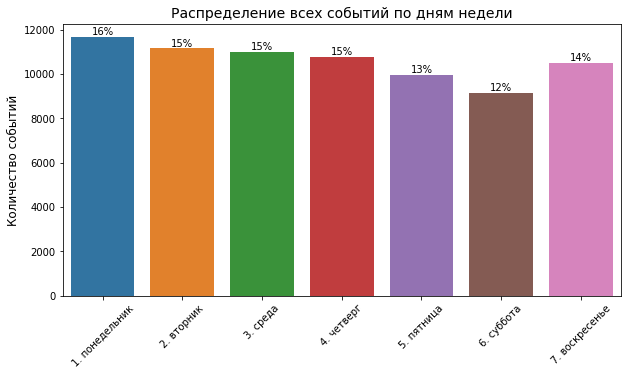

In [55]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='weekday', 
                 y='event_count', 
                 data=events_by_day)
for bar, percentage in zip(ax.patches, events_by_day['shape_of_events']):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,
        f'{percentage}', 
        ha='center', 
        va='bottom', 
        fontsize=10
    )
    
plt.title('Распределение всех событий по дням недели', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(rotation=45)
plt.show();

- В целом, распределение событий в течении недели достаточно равномерно, с небольшими колебаниями. 
- Наибольшая активность наблюдается в понедельник (16% событий).
- В течении рабочей недели идет плавное снижение активности (до 13% событий в пятницу).
- Минимальное количество событий приходится на субботу - 12%.
- В воскресенье пользователи более активно взаимодействуют с приложением и уровень повышается до 14% событий.

In [56]:
type_events_by_day = df.pivot_table(index='weekday',
                                   columns='event_name',
                                   values='user_id',
                                   aggfunc='count',
                                   fill_value=0)\
                       .sort_index()

type_events_by_day.style.background_gradient(cmap='PuBu')

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
weekday,,,,,,,,,
1. понедельник,1121,73,646,142,836,1202,948,147,6556
2. вторник,952,86,708,303,642,1316,1106,113,5919
3. среда,845,74,715,239,545,1329,987,111,6150
4. четверг,783,118,825,191,547,1291,909,120,5978
5. пятница,738,53,665,142,426,1371,939,122,5513
6. суббота,694,67,447,161,414,1664,931,83,4693
7. воскресенье,1031,70,523,239,471,1839,964,118,5246


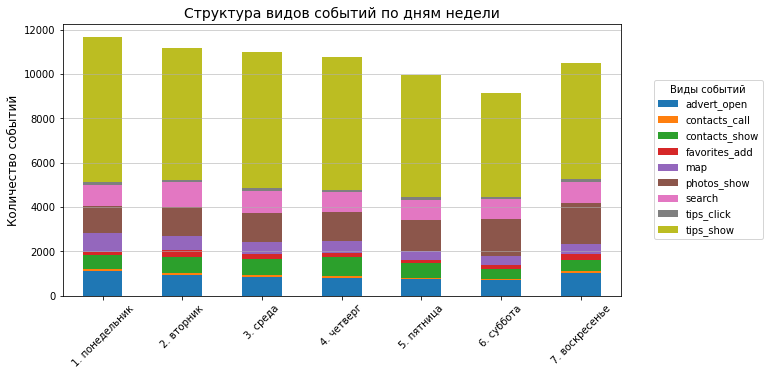

In [57]:
type_events_by_day.plot(kind='bar',
                        stacked=True,
                        figsize=(10,5))

plt.title('Структура видов событий по дням недели', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.7)
plt.legend(title='Виды событий', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show();

- Структура событий по дням недели в целом стабильна, с доминированием события "просмотр рекомендаций" во все дни.
- При этом, интересно отметить некоторые поведенческие сдвиги:
    - в понедельник, чаще чем в другие дни, пользователи смотрят рекомендации, кликают на них и открывают нужные объявления,
    - во вторник, пользователи больше, чем в другие дни, занимаются поиском и добавлением в "избранное",
    - в воскресенье пользователи больше, чем в другие дни, просматривают фото объявлений.

##### Вывод о распределение событий по дням недели:
- В целом, активность пользователей в течении недели равномерная.
- Пик активности приходится на понедельник, а минимальный уровень - в субботу.
- В течение недели заметна незначительная тенденция к снижению, однако в воскресенье активность возрастает.
- Структура взаимодействия остается стабильной - с доминированием события "просмотр рекомендаций" во все дни.
- При этом, наблюдаются некоторые поведенческие особенности:
    - в понедельник пользователи просматриваю и кликаю рекомендации, заходят в объявления,
    - во вторник пользователи в большей степени проявляют активную позицию - занимаясь поиском и добавлением в "избранное",
    - в воскресенье отдают предпочтение "пассивному" взаимодействию с приложением, просматривая фото объявлений.

#### Распределение событий по будням и выходным 

In [58]:
df['workdays_weekend'] = df['events_by_weekday'].copy()

def rename(typeday):
    if typeday == 0:
        return 'workdays'
    elif typeday == 1:
        return 'workdays'
    elif typeday == 2:
        return 'workdays'
    elif typeday == 3:
        return 'workdays'    
    elif typeday == 4:
        return 'workdays'    
    elif typeday == 5:
        return 'weekend'    
    elif typeday == 6:
        return 'weekend'    
    else:
        return 'неопределено'    

df['workdays_weekend'] = df['workdays_weekend'].apply(rename)    

df['workdays_weekend'].unique()

array(['workdays', 'weekend'], dtype=object)

In [59]:
events_by_workdays_weekend = df.groupby('workdays_weekend')['event_name']\
                  .count()\
                  .reset_index()\
                  .rename(columns={'event_name': 'event_count'})

events_by_workdays_weekend['shape_of_events'] = (events_by_workdays_weekend['event_count']/events_by_workdays_weekend['event_count'].sum())\
                                    .map("{:.0%}".format)

events_by_workdays_weekend

,workdays_weekend,event_count,shape_of_events
0,weekend,19655,26%
1,workdays,54542,74%


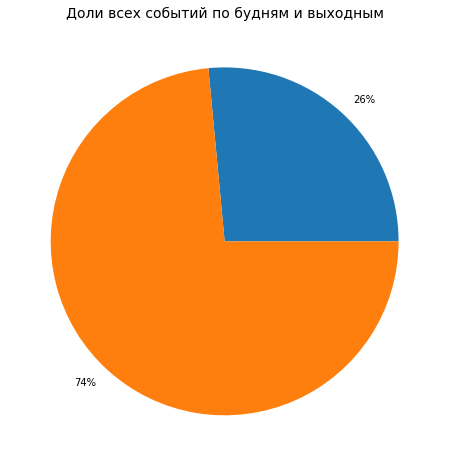

In [60]:
plt.figure(figsize=(8,8))
plt.pie(events_by_workdays_weekend['event_count'],
        labels=events_by_workdays_weekend['shape_of_events'])
    
plt.title('Доли всех событий по будням и выходным', fontsize=14)
plt.xlabel('', fontsize=12)
plt.show();

Равномерная активность пользователей в течение недели совершенно логично сформировала структуру аутивности в будни и выходные: 74% событий происходи в будни и 26%  в выходные. 

In [61]:
type_events_by_workdays_weekend = df.pivot_table(index='workdays_weekend',
                                   columns='event_name',
                                   values='user_id',
                                   aggfunc='count',
                                   fill_value=0)\
                       .sort_index()

type_events_by_workdays_weekend

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
workdays_weekend,,,,,,,,,
weekend,1725,137,970,400,885,3503,1895,201,9939
workdays,4439,404,3559,1017,2996,6509,4889,613,30116


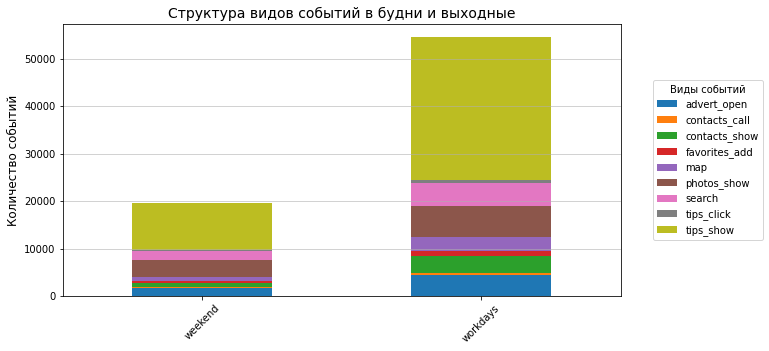

In [62]:
type_events_by_workdays_weekend.plot(kind='bar',
                                     stacked=True,
                                     figsize=(10,5))

plt.title('Структура видов событий в будни и выходные', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.7)
plt.legend(title='Виды событий', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show();

##### Вывод о распределение событий по будням и выходным:
- В целом, поведение по будням и выходным позволяет лишь расширить фокус внимания, по сравнению с анализом действий по дням.
- В будни пользователи в большей степени используют приложение целенаправленно на поиск и просмотр объявлений, контактной информации и добавление в "избранное".
- В выходные поведение пользователей более пассивное (просмотр рекомендаций и фото), а к активным действиям переходят реже.

#### Распределение событий в течении суток 

In [63]:
df['hour'] = df['event_time'].dt.hour

events_by_24h = df.groupby('hour')['event_name']\
                  .count()\
                  .reset_index()\
                  .rename(columns={'event_name': 'event_count_per_24h'})

events_by_24h['shape_of_events_by_24h'] = (events_by_24h['event_count_per_24h']/events_by_24h['event_count_per_24h'].sum())\
                                    .map("{:.1%}".format)

events_by_24h.style.background_gradient(cmap='PuBu')

,hour,event_count_per_24h,shape_of_events_by_24h
0,0,1642,2.2%
1,1,940,1.3%
2,2,560,0.8%
3,3,299,0.4%
4,4,184,0.2%
5,5,166,0.2%
6,6,356,0.5%
7,7,532,0.7%
8,8,1776,2.4%
9,9,3075,4.1%


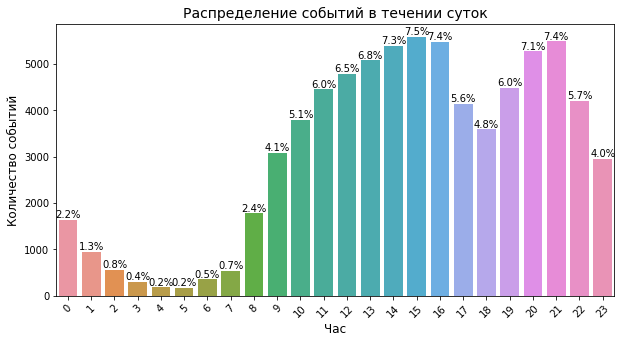

In [64]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='hour', 
                 y='event_count_per_24h', 
                 data=events_by_24h)
for bar, percentage in zip(ax.patches, events_by_24h['shape_of_events_by_24h']):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,
        f'{percentage}', 
        ha='center', 
        va='bottom', 
        fontsize=10
    )
    
plt.title('Распределение событий в течении суток', fontsize=14)
plt.xlabel('Час', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(rotation=45)
plt.show();

##### Вывод о распределение событий в течении суток:
- Низкий уровень активности в приложении наблюдается с 23 часов до 7 утра, при этом с 3 до 6 часов утра активность приближается к нулю.
- С 8 утра начинается плавный рост активности, который достигает первого пика в дневные часы (с 13 до 15 часов), и затем снижение взаимодействия с приложением до 18 часов.
- После окончания "рабочего дня" пользователи возвращаются в приложением и второй пик активности фиксируется в 21 час, с последующим снижением до утра.

#### Распределение событий по частям дня

Создадим категории времени суток:

In [65]:
df['hour'] = df['event_time'].dt.hour
df['part_of_day'] = pd.cut(df['hour'], 
                           bins=[0, 6, 12, 18, 24],
                          labels=['ночь', 'утро', 'день', 'вечер'],
                          right=False)

df['part_of_day'].unique()

['день', 'вечер', 'утро', 'ночь']
Categories (4, object): ['ночь' < 'утро' < 'день' < 'вечер']

Расчитаем количество событий в разное время суток:

In [66]:
events_by_time = df.groupby('part_of_day')['event_name']\
                  .count()\
                  .reset_index()\
                  .rename(columns={'event_name': 'event_count_per_day'})

events_by_time['shape_of_events'] = (events_by_time['event_count_per_day']/events_by_time['event_count_per_day'].sum())\
                                    .map("{:.0%}".format)

events_by_time

,part_of_day,event_count_per_day,shape_of_events
0,ночь,3791,5%
1,утро,13976,19%
2,день,30454,41%
3,вечер,25976,35%


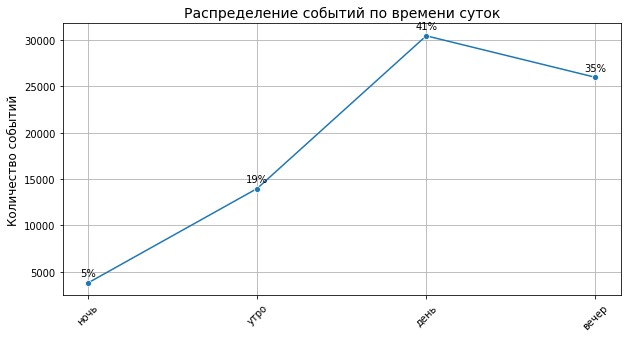

In [67]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x='part_of_day', 
                 y='event_count_per_day', 
                 data=events_by_time,
                 marker='o')
for i, (x, y) in enumerate(zip(events_by_time['part_of_day'],
                               events_by_time['event_count_per_day'])):
    percentage = events_by_time['shape_of_events'][i]
    ax.text(x, 
            y + 500, 
            percentage, 
            ha='center', 
            va='bottom', 
        )

ax.grid(True)    
plt.title('Распределение событий по времени суток', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(rotation=45)
plt.show();

In [68]:
type_events_by_time = df.pivot_table(index='part_of_day',
                                   columns='event_name',
                                   values='user_id',
                                   aggfunc='count',
                                   fill_value=0)\
                       .sort_index()

type_events_by_time.style.background_gradient(cmap='PuBu')

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
part_of_day,,,,,,,,,
ночь,385,3,85,130,141,774,417,39,1817
утро,1099,111,1050,232,814,1674,1253,130,7613
день,2506,306,2275,550,1764,2926,2473,363,17291
вечер,2174,121,1119,505,1162,4638,2641,282,13334


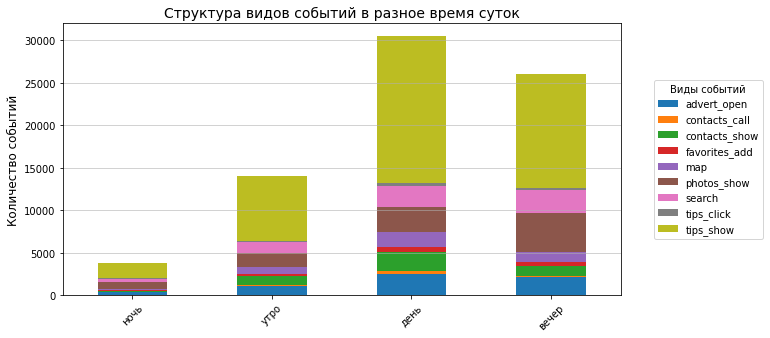

In [69]:
type_events_by_time.plot(kind='bar',
                                     stacked=True,
                                     figsize=(10,5))

plt.title('Структура видов событий в разное время суток', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.7)
plt.legend(title='Виды событий', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show();

##### Вывод о распределение событий по частям дня:
-  Максимальное количество действий совершается днем (41% всех событий). Это период наивысшей активности.
- Вечером активность немного снижается (35% событий). При этом, продолжается активное взаимодействие с приложением.
- Утро характеризуется умеренной активностью, но пользователи предпочитают пассивное взаимодействие (просмотр рекомендаций и фото).
- Ночью приложение используется скорее в фоновом режиме.

#### Вывод о частоте событий:
- Анализ частоты событий показывает, что поведение пользователей в основном сконцентрировано на пассивных действиях (просмотры рекомендаций и фото), и в меньшей степени на активных действиях (поиск и просмотр конкретных объявлений, просмотр контактов и добавление в "избранное").
- В целом, можно говорить о поверхностной вовлеченности большинства пользователей. Однако, причина такого поведения могут быть противоположные: как удобство приложения и отсутствие необходимости долгого и глубокого взаимодействия, так и отсутствие нужных объявлений и другой релевантной информации.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

Во многих продуктах в выходные наблюдается спад активности. Все стараются максимально использовать это время для отдыха, семьи и т.д. Так что вполне логичные результаты.

### Конверсия в целевое действие - `просмотр контактов`

Определим количество уникальных пользователей:

In [70]:
unique_users = df['user_id'].nunique()

print(f'Всего {unique_users} уникальных пользователей.')

Всего 4293 уникальных пользователей.


Определим количество пользователей, совершивших целевое действие:

In [71]:
users_to_target = df.query('event_name == "contacts_show"')['user_id'].nunique()
print(f'Всего {users_to_target} уникальных пользователей, совершивших целевое действие ("просмотр контактов").')

Всего 981 уникальных пользователей, совершивших целевое действие ("просмотр контактов").


Расчитаем конверсия в целевое действие:

In [72]:
conversion_rate = round((users_to_target/unique_users)*100, 2)
print(f'Конверсия в целевое действие ("просмотр контактов") составляет - {conversion_rate}%.')

Конверсия в целевое действие ("просмотр контактов") составляет - 22.85%.


#### Вывод по общей конверсии в целевое действие (просмотр контактов):
- Почти каждый четвертый пользователь приложения (22,85%) проявил интерес к объявлению и просмотрел контакты.
- Данный уровень конверсии достаточно высокий показатель вовлеченности.   
- Учитывая не высокий уровень частоты взаимодействия с приложения, выявленном при анализе частоты событий, но уверенную конверсию, можно предположить, что приложение скорее удобное (например, эффективная навигация) и пользователь быстро находит релевантные объявления. 

## Сегментация

### Сегментация пользователей по уровню вовлеченности:

**Обоснование сегментации:**
- В качестве метрики выбрано время взаимодействия, поскольку оно более явно показывает вовлечённость пользователей (например, чем количество сессий или событий).
- Границы сегментов установлены на основе квартилей и статистического анализа распределения длительности сессий.
- Такой подход позволяет:
    - выделить наиболее заинтересованных пользователей (высокая вовлеченность),
    - отследить поведение тех, кто ограничивается быстрым или разовым взаимодействием (низкая вовлеченность),
    - отдельно анализировать умеренную аудиторию, которая может быть перспективной для вовлечения в целевые действия.

**Практическая ценность:**
- Данная сегментация позволяет адресно применять маркетинговые и продуктовые решения — например, персонализировать коммуникацию, запускать push-уведомления или предложения для разных уровней вовлеченности.

Расмотрим распределение действий на пользователя:

In [73]:
user_total_time = session_time.groupby('user_id')\
                              .agg(total_duration=('session_duration', 'sum'))\
                              .reset_index()

user_total_time['total_minutes'] = (user_total_time['total_duration']/60).round(0)

Разделим пользователей по уровню активности в приложении (количеству сессии) следующим группа:
- "низкая вовлеченность" (до 6 минут включительно),
- "средняя вовлеченность" (от 6 до 17 минут включительно),
- "высокая вовлеченность" (свыше 17 минут).

In [74]:
user_total_time['segments'] = user_total_time['total_minutes'].apply(
    lambda x: 'низкая вовлеченность'if x <= 6 else (
        'средняя вовлеченность' if 6 < x <= 17 else 'высокая вовлеченность'
    )
)

segments = user_total_time['segments'].value_counts()\
                           .reset_index()\
                           .rename(columns={'index': 'segment_name',
                                             'segments': 'users_count'})
segments

,segment_name,users_count
0,высокая вовлеченность,1958
1,средняя вовлеченность,1184
2,низкая вовлеченность,1151


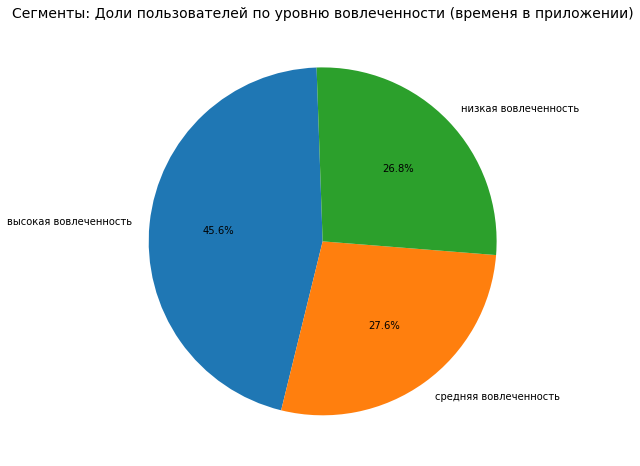

In [75]:
plt.figure(figsize=(8,8))
plt.pie(segments['users_count'],
        labels=segments['segment_name'],
        autopct='%1.1f%%',
        startangle=92)
    
plt.title('Сегменты: Доли пользователей по уровню вовлеченности (временя в приложении)', fontsize=14)
plt.xlabel('', fontsize=12)
plt.show();

In [76]:
df = df.merge(user_total_time[['user_id', 'segments']],
              on='user_id',
              how='left')

- Пользователи были сегментированы по общему времени, проведенному в приложении:
    - "низкая вовлеченность" - 26,8% пользователей,
    - "средняя вовлеченность" - 27,6% пользователей,
    - значительная часть пользователей относятся к сегменту с "высокой вовлеченностью" - 45,6% пользователей).

### Удержание пользователей (retention rate) в разных сегментах:

Построим таблицы удержания для каждого сегмента пользователей: 

#### Сегмент 1 - с "низкой вовлеченностью" (пользователи, которые провели в приложении менее 6 минут)

In [77]:
low_segment = df.query('segments == "низкая вовлеченность"')

In [78]:
retention_table_low_segment = low_segment.pivot_table(
    index=['first_day_visit'],
    columns='lifetime',
    values='user_id',
    aggfunc='nunique'
).fillna(0)
retention_table_low_segment

lifetime,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,53.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0
2019-10-08,44.0,6.0,3.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2019-10-09,47.0,4.0,2.0,3.0,3.0,3.0,3.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-10,44.0,2.0,0.0,3.0,0.0,3.0,0.0,0.0,2.0,2.0,...,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-10-11,31.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-10-12,29.0,4.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-10-13,31.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14,40.0,3.0,4.0,4.0,4.0,1.0,0.0,3.0,3.0,2.0,...,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-15,56.0,5.0,5.0,5.0,3.0,2.0,1.0,1.0,2.0,1.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Вычислим размеры когорт:

In [79]:
low_cohort_sizes = low_segment.groupby('first_day_visit')\
                              .agg({'user_id': 'nunique'})\
                              .rename(columns={'user_id': 'low_cohort_sizes'})
low_cohort_sizes

,low_cohort_sizes
first_day_visit,
2019-10-07,53
2019-10-08,44
2019-10-09,47
2019-10-10,44
2019-10-11,31
2019-10-12,29
2019-10-13,31
2019-10-14,40
2019-10-15,56


Объеденим размеры когорт и таблицe удержания:

In [80]:
retention_table_curr_low = low_cohort_sizes.merge(retention_table_low_segment,
                                                  on='first_day_visit',
                                                  how='left').fillna(0)

retention_table_curr_low

,low_cohort_sizes,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,53,53.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0
2019-10-08,44,44.0,6.0,3.0,2.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2019-10-09,47,47.0,4.0,2.0,3.0,3.0,3.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-10,44,44.0,2.0,0.0,3.0,0.0,3.0,0.0,0.0,2.0,...,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-10-11,31,31.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-10-12,29,29.0,4.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-10-13,31,31.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14,40,40.0,3.0,4.0,4.0,4.0,1.0,0.0,3.0,3.0,...,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-15,56,56.0,5.0,5.0,5.0,3.0,2.0,1.0,1.0,2.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Расчитаем retention rate (в виде долей от 0 до 1):

In [81]:
retention_rate_low = retention_table_curr_low.div(retention_table_curr_low['low_cohort_sizes'], axis=0)

retention_rate_low.drop(columns=['low_cohort_sizes'], inplace=True)

retention_rate_low

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,1.0,0.037736,0.037736,0.075472,0.037736,0.037736,0.018868,0.018868,0.018868,0.000000,...,0.000000,0.018868,0.018868,0.000000,0.018868,0.037736,0.000000,0.018868,0.018868,0.018868
2019-10-08,1.0,0.136364,0.068182,0.045455,0.022727,0.022727,0.000000,0.000000,0.022727,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.022727,0.000000
2019-10-09,1.0,0.085106,0.042553,0.063830,0.063830,0.063830,0.063830,0.042553,0.021277,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-10,1.0,0.045455,0.000000,0.068182,0.000000,0.068182,0.000000,0.000000,0.045455,0.045455,...,0.022727,0.022727,0.000000,0.045455,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000
2019-10-11,1.0,0.064516,0.064516,0.064516,0.064516,0.000000,0.000000,0.000000,0.032258,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-12,1.0,0.137931,0.103448,0.034483,0.034483,0.000000,0.034483,0.000000,0.000000,0.034483,...,0.034483,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-13,1.0,0.032258,0.096774,0.000000,0.000000,0.000000,0.032258,0.032258,0.096774,0.064516,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-14,1.0,0.075000,0.100000,0.100000,0.100000,0.025000,0.000000,0.075000,0.075000,0.050000,...,0.075000,0.000000,0.075000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-15,1.0,0.089286,0.089286,0.089286,0.053571,0.035714,0.017857,0.017857,0.035714,0.017857,...,0.035714,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Построим карту:

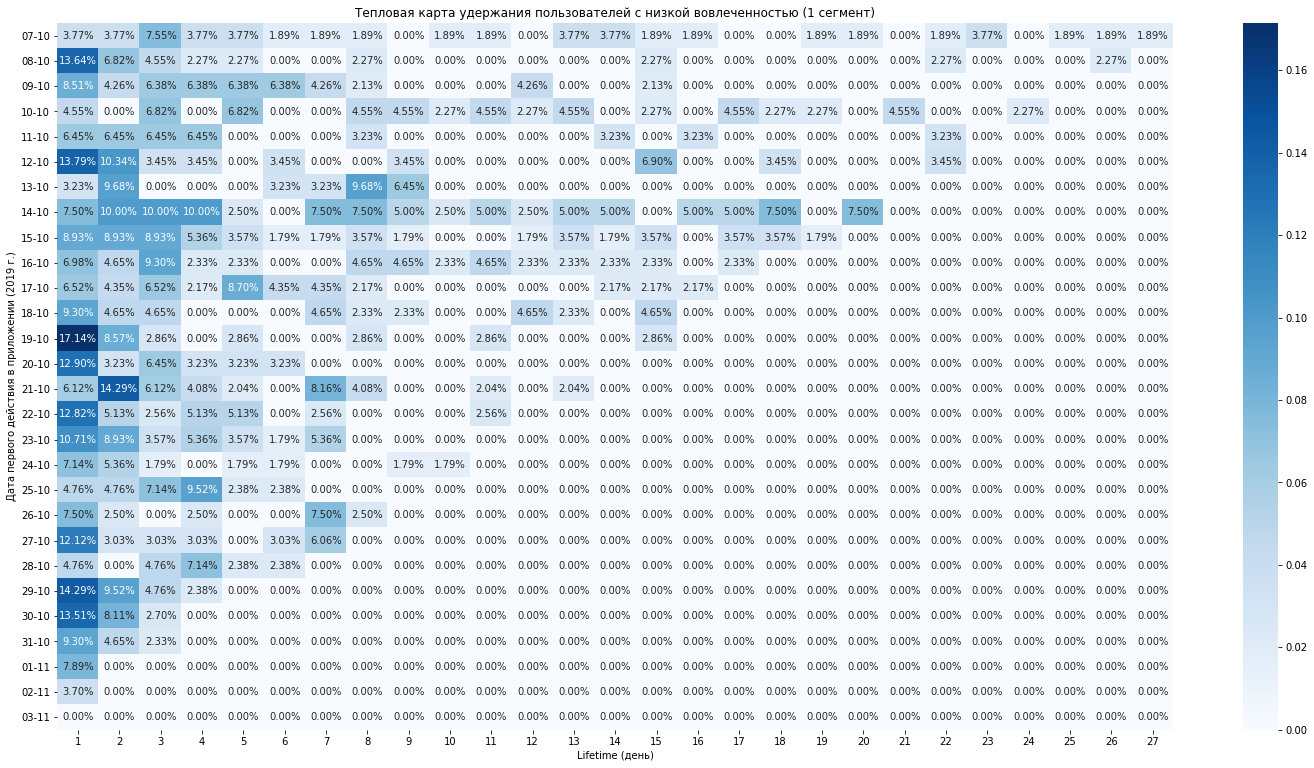

In [82]:
plt.figure(figsize=(20,10))
ax=sns.heatmap(
    retention_rate_low.drop(columns=[0]),
    annot=True,
    fmt='.2%',
    cmap='Blues'
)

ticklabels = [retention_rate_low.index[int(tick)]\
              .strftime('%d-%m') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels)

ax.figure.set_size_inches(25,13)
plt.title('Тепловая карта удержания пользователей с низкой вовлеченностью (1 сегмент)')
plt.xlabel('Lifetime (день)')
plt.ylabel('Дата первого действия в приложении (2019 г.)')

plt.show();

##### Вывод по удержанию пользователей 1го сегмента:
- Удержание пользователей в данной группе невысокое. Уже на второй день остается в среднем менее 6%, а к 7му дню - менее 3%.
- Отдельные когорты демонстрируют немного более высокие показатели:
    - 13,14 и 17 октября: когорты с удержанием на 2-3 день более 8%.    

#### Сегмент 2 - со "средней вовлеченностью" (пользователи, которые провели в приложении от 6 до 17 минут):

In [83]:
middle_segment = df.query('segments == "средняя вовлеченность"')

In [84]:
retention_table_middle_segment = middle_segment.pivot_table(
    index=['first_day_visit'],
    columns='lifetime',
    values='user_id',
    aggfunc='nunique'
).fillna(0)

retention_table_middle_segment

lifetime,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,47.0,6.0,4.0,6.0,4.0,2.0,1.0,3.0,2.0,1.0,...,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0
2019-10-08,42.0,3.0,3.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2019-10-09,55.0,2.0,3.0,4.0,2.0,4.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2019-10-10,55.0,3.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0,2.0,...,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2019-10-11,42.0,2.0,4.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0
2019-10-12,33.0,1.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-13,40.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14,43.0,8.0,2.0,3.0,4.0,1.0,1.0,0.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-15,39.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Вычислим размеры когорт:

In [85]:
middle_cohort_sizes = middle_segment.groupby('first_day_visit')\
                                    .agg({'user_id': 'nunique'})\
                                    .rename(columns={'user_id': 'middle_cohort_sizes'})
middle_cohort_sizes

,middle_cohort_sizes
first_day_visit,
2019-10-07,47
2019-10-08,42
2019-10-09,55
2019-10-10,55
2019-10-11,42
2019-10-12,33
2019-10-13,40
2019-10-14,43
2019-10-15,39


Объеденим размеры когорт и таблицe удержания:

In [86]:
retention_table_curr_middle = middle_cohort_sizes.merge(retention_table_middle_segment,
                                                        on='first_day_visit',
                                                        how='left').fillna(0)

retention_table_curr_middle

,middle_cohort_sizes,0,1,2,3,4,5,6,7,8,...,17,18,19,20,21,22,23,24,25,26
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,47,47.0,6.0,4.0,6.0,4.0,2.0,1.0,3.0,2.0,...,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0
2019-10-08,42,42.0,3.0,3.0,4.0,1.0,0.0,2.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2019-10-09,55,55.0,2.0,3.0,4.0,2.0,4.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2019-10-10,55,55.0,3.0,1.0,3.0,1.0,0.0,1.0,0.0,1.0,...,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2019-10-11,42,42.0,2.0,4.0,3.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0
2019-10-12,33,33.0,1.0,0.0,3.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-13,40,40.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14,43,43.0,8.0,2.0,3.0,4.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-15,39,39.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Расчитаем retention rate (в виде долей от 0 до 1):

In [87]:
retention_rate_middle = retention_table_curr_middle.div(retention_table_curr_middle['middle_cohort_sizes'], axis=0)

retention_rate_middle.drop(columns=['middle_cohort_sizes'], inplace=True)

retention_rate_middle

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,1.0,0.127660,0.085106,0.127660,0.085106,0.042553,0.021277,0.063830,0.042553,0.021277,...,0.042553,0.042553,0.021277,0.021277,0.000000,0.000000,0.000000,0.00000,0.063830,0.021277
2019-10-08,1.0,0.071429,0.071429,0.095238,0.023810,0.000000,0.047619,0.000000,0.000000,0.023810,...,0.023810,0.000000,0.023810,0.023810,0.023810,0.023810,0.023810,0.02381,0.000000,0.000000
2019-10-09,1.0,0.036364,0.054545,0.072727,0.036364,0.072727,0.018182,0.018182,0.018182,0.018182,...,0.000000,0.000000,0.018182,0.000000,0.018182,0.000000,0.000000,0.00000,0.018182,0.000000
2019-10-10,1.0,0.054545,0.018182,0.054545,0.018182,0.000000,0.018182,0.000000,0.018182,0.036364,...,0.000000,0.036364,0.018182,0.000000,0.018182,0.018182,0.000000,0.00000,0.000000,0.000000
2019-10-11,1.0,0.047619,0.095238,0.071429,0.047619,0.023810,0.023810,0.023810,0.023810,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.047619,0.023810,0.047619,0.00000,0.000000,0.000000
2019-10-12,1.0,0.030303,0.000000,0.090909,0.030303,0.060606,0.000000,0.000000,0.030303,0.030303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2019-10-13,1.0,0.075000,0.025000,0.025000,0.025000,0.025000,0.000000,0.000000,0.000000,0.025000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2019-10-14,1.0,0.186047,0.046512,0.069767,0.093023,0.023256,0.023256,0.000000,0.023256,0.046512,...,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2019-10-15,1.0,0.051282,0.025641,0.051282,0.025641,0.000000,0.025641,0.025641,0.025641,0.025641,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


Построим карту:

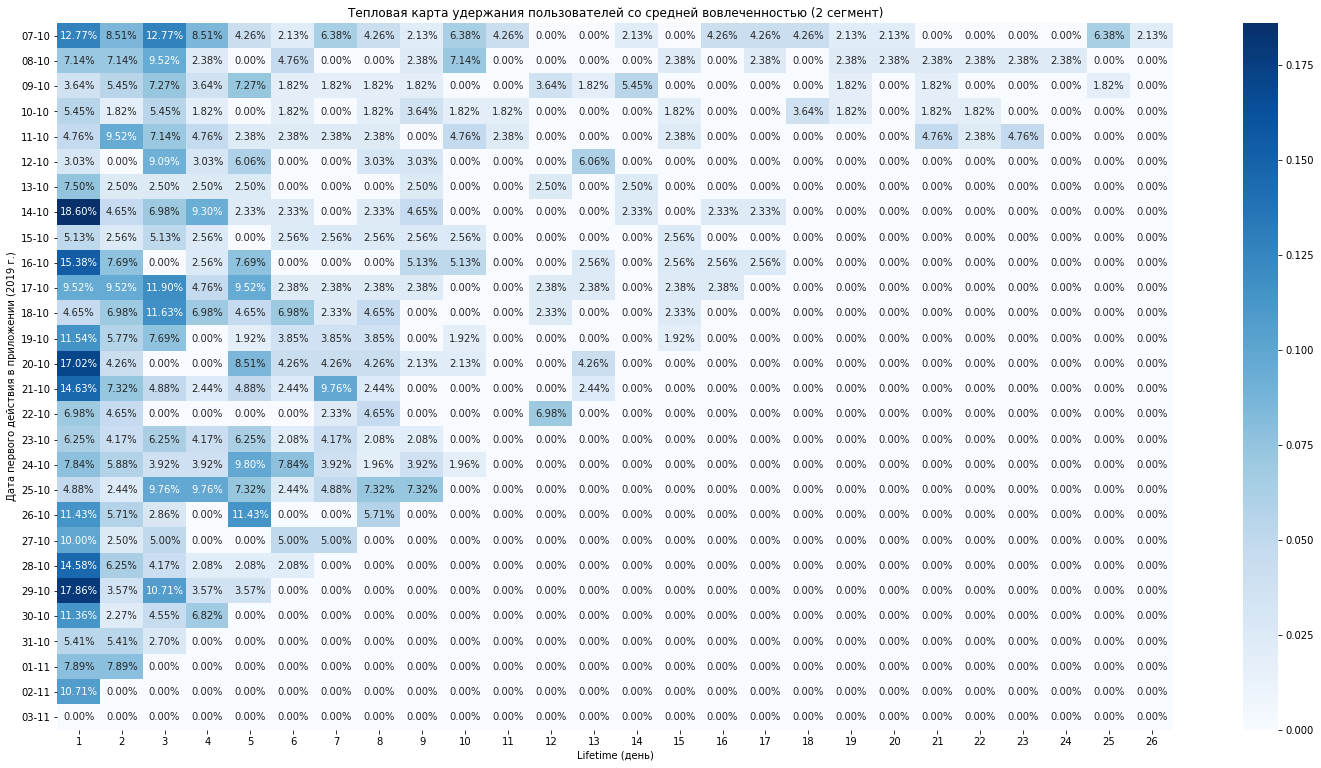

In [88]:
plt.figure(figsize=(20,10))
ax=sns.heatmap(
    retention_rate_middle.drop(columns=[0]),
    annot=True,
    fmt='.2%',
    cmap='Blues'
)

ticklabels = [retention_rate_middle.index[int(tick)]\
              .strftime('%d-%m') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels)

ax.figure.set_size_inches(25,13)
plt.title('Тепловая карта удержания пользователей со средней вовлеченностью (2 сегмент)')
plt.xlabel('Lifetime (день)')
plt.ylabel('Дата первого действия в приложении (2019 г.)')

plt.show();

##### Вывод по удержанию пользователей 2го сегмента:
- В течение 1-3 дней удерживается 7%-12% пользователей данного сегмента.
- Хорошим показателем является удержание на 4ый день на уровне 8-10% у когорт 7, 13 и 20 октября.
- Удержание плавно снижается. Некоторые пользователи возвращаются на 3-5 день.
- Средний уровень удержания стабилен и сохраняется до 7 дня у ряда когорт.

#### Сегмент 3 - со "высокой вовлеченностью" (пользователи, которые провели в приложении свыше 17 минут):

In [89]:
high_segment = df.query('segments == "высокая вовлеченность"')

In [90]:
retention_table_high_segment = high_segment.pivot_table(
    index=['first_day_visit'],
    columns='lifetime',
    values='user_id',
    aggfunc='nunique'
).fillna(0)

retention_table_high_segment

lifetime,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,104.0,29.0,15.0,12.0,8.0,8.0,6.0,12.0,10.0,9.0,...,4.0,6.0,0.0,4.0,7.0,4.0,4.0,6.0,2.0,2.0
2019-10-08,81.0,21.0,14.0,11.0,4.0,5.0,9.0,8.0,10.0,8.0,...,2.0,5.0,7.0,2.0,2.0,5.0,4.0,5.0,4.0,0.0
2019-10-09,74.0,11.0,10.0,3.0,5.0,7.0,6.0,7.0,8.0,8.0,...,2.0,4.0,3.0,1.0,5.0,1.0,3.0,4.0,0.0,0.0
2019-10-10,75.0,19.0,12.0,12.0,12.0,13.0,10.0,13.0,8.0,6.0,...,4.0,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0
2019-10-11,63.0,8.0,5.0,13.0,9.0,8.0,7.0,9.0,1.0,0.0,...,5.0,4.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
2019-10-12,63.0,20.0,12.0,9.0,6.0,7.0,12.0,10.0,8.0,6.0,...,4.0,4.0,2.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0
2019-10-13,77.0,22.0,9.0,7.0,10.0,8.0,5.0,11.0,4.0,6.0,...,4.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14,102.0,20.0,11.0,11.0,11.0,11.0,9.0,7.0,6.0,6.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-15,91.0,21.0,13.0,10.0,7.0,8.0,10.0,11.0,13.0,4.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Вычислим размеры когорт:

In [91]:
high_cohort_sizes = high_segment.groupby('first_day_visit')\
                                  .agg({'user_id': 'nunique'})\
                                  .rename(columns={'user_id': 'high_cohort_sizes'})
high_cohort_sizes

,high_cohort_sizes
first_day_visit,
2019-10-07,104
2019-10-08,81
2019-10-09,74
2019-10-10,75
2019-10-11,63
2019-10-12,63
2019-10-13,77
2019-10-14,102
2019-10-15,91


Объеденим размеры когорт и таблицe удержания:

In [92]:
retention_table_curr_high = high_cohort_sizes.merge(retention_table_high_segment,
                                                    on='first_day_visit',
                                                    how='left').fillna(0)

retention_table_curr_high

,high_cohort_sizes,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,104,104.0,29.0,15.0,12.0,8.0,8.0,6.0,12.0,10.0,...,4.0,6.0,0.0,4.0,7.0,4.0,4.0,6.0,2.0,2.0
2019-10-08,81,81.0,21.0,14.0,11.0,4.0,5.0,9.0,8.0,10.0,...,2.0,5.0,7.0,2.0,2.0,5.0,4.0,5.0,4.0,0.0
2019-10-09,74,74.0,11.0,10.0,3.0,5.0,7.0,6.0,7.0,8.0,...,2.0,4.0,3.0,1.0,5.0,1.0,3.0,4.0,0.0,0.0
2019-10-10,75,75.0,19.0,12.0,12.0,12.0,13.0,10.0,13.0,8.0,...,4.0,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0
2019-10-11,63,63.0,8.0,5.0,13.0,9.0,8.0,7.0,9.0,1.0,...,5.0,4.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
2019-10-12,63,63.0,20.0,12.0,9.0,6.0,7.0,12.0,10.0,8.0,...,4.0,4.0,2.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0
2019-10-13,77,77.0,22.0,9.0,7.0,10.0,8.0,5.0,11.0,4.0,...,4.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14,102,102.0,20.0,11.0,11.0,11.0,11.0,9.0,7.0,6.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-15,91,91.0,21.0,13.0,10.0,7.0,8.0,10.0,11.0,13.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Расчитаем retention rate (в виде долей от 0 до 1):

In [93]:
retention_rate_high = retention_table_curr_high.div(retention_table_curr_high['high_cohort_sizes'], axis=0)

retention_rate_high.drop(columns=['high_cohort_sizes'], inplace=True)

retention_rate_high

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
first_day_visit,,,,,,,,,,,,,,,,,,,,,
2019-10-07,1.0,0.278846,0.144231,0.115385,0.076923,0.076923,0.057692,0.115385,0.096154,0.086538,...,0.038462,0.057692,0.000000,0.038462,0.067308,0.038462,0.038462,0.057692,0.019231,0.019231
2019-10-08,1.0,0.259259,0.172840,0.135802,0.049383,0.061728,0.111111,0.098765,0.123457,0.098765,...,0.024691,0.061728,0.086420,0.024691,0.024691,0.061728,0.049383,0.061728,0.049383,0.000000
2019-10-09,1.0,0.148649,0.135135,0.040541,0.067568,0.094595,0.081081,0.094595,0.108108,0.108108,...,0.027027,0.054054,0.040541,0.013514,0.067568,0.013514,0.040541,0.054054,0.000000,0.000000
2019-10-10,1.0,0.253333,0.160000,0.160000,0.160000,0.173333,0.133333,0.173333,0.106667,0.080000,...,0.053333,0.040000,0.040000,0.040000,0.040000,0.040000,0.026667,0.000000,0.000000,0.000000
2019-10-11,1.0,0.126984,0.079365,0.206349,0.142857,0.126984,0.111111,0.142857,0.015873,0.000000,...,0.079365,0.063492,0.063492,0.031746,0.015873,0.015873,0.000000,0.000000,0.000000,0.000000
2019-10-12,1.0,0.317460,0.190476,0.142857,0.095238,0.111111,0.190476,0.158730,0.126984,0.095238,...,0.063492,0.063492,0.031746,0.111111,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-13,1.0,0.285714,0.116883,0.090909,0.129870,0.103896,0.064935,0.142857,0.051948,0.077922,...,0.051948,0.038961,0.012987,0.064935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-14,1.0,0.196078,0.107843,0.107843,0.107843,0.107843,0.088235,0.068627,0.058824,0.058824,...,0.019608,0.009804,0.009804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-10-15,1.0,0.230769,0.142857,0.109890,0.076923,0.087912,0.109890,0.120879,0.142857,0.043956,...,0.032967,0.032967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Построим карту:

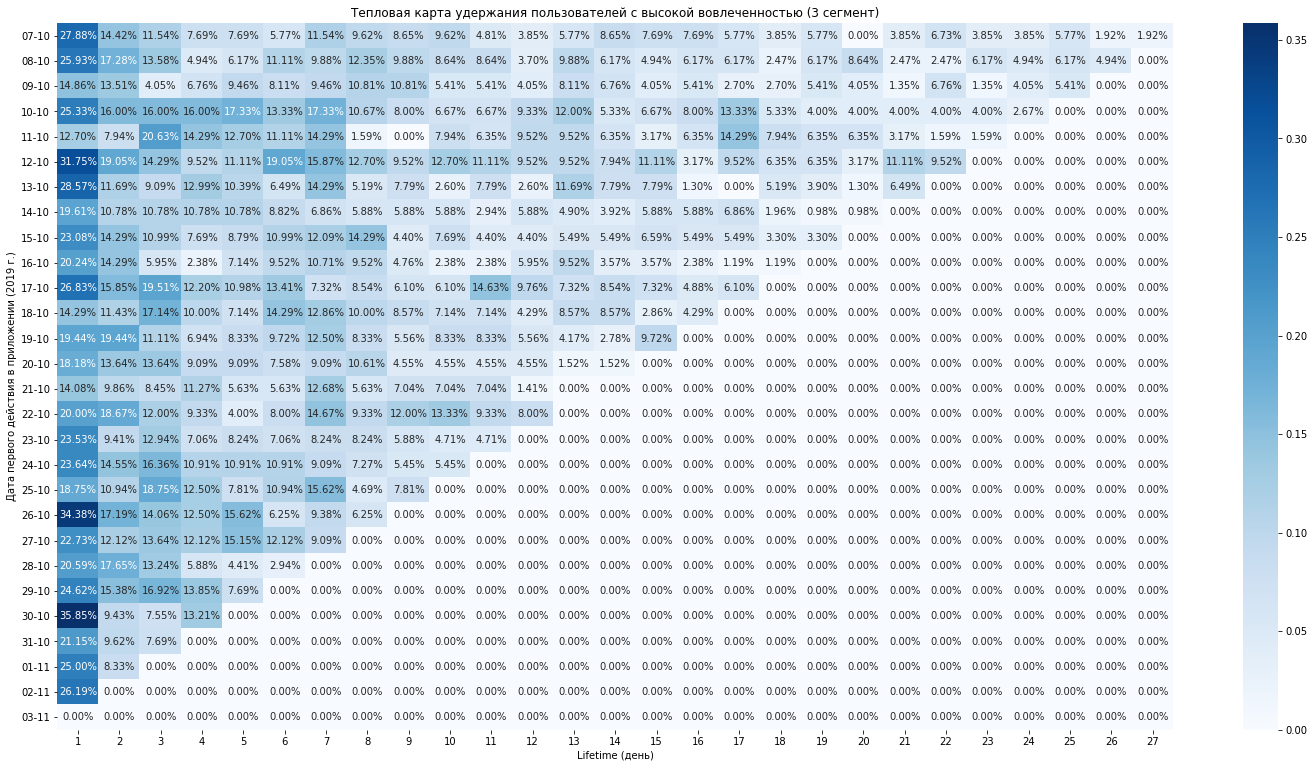

In [94]:
plt.figure(figsize=(20,10))
ax=sns.heatmap(
    retention_rate_high.drop(columns=[0]),
    annot=True,
    fmt='.2%',
    cmap='Blues'
)

ticklabels = [retention_rate_high.index[int(tick)]\
              .strftime('%d-%m') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels)

ax.figure.set_size_inches(25,13)
plt.title('Тепловая карта удержания пользователей с высокой вовлеченностью (3 сегмент)')
plt.xlabel('Lifetime (день)')
plt.ylabel('Дата первого действия в приложении (2019 г.)')

plt.show();

##### Вывод по удержанию пользователей 3го сегмента:
- Высокий старт удержания: в большом количестве когорт более 25% пользователей во второй день.
- Пользователи данного сегмента сохраняют интерес к приложению в течении не менее чем 7 дней.
- Наиболее стабильное удержание наблюдается у когорт второй половины октября.

#### Общий вывод по удержанию по сегментам:
- Retention rate в разных сегментах демонстрирует разные уровни удержания:
    - сегмент 1 (с низкой вовлеченностью) - слабое удержание пользователей. Вореоятно, пользователи не находят ценности в данном приложении.
    - сегмент 2 (со средней вовлеченностью) - достаточно высокий уровень удержания. Это говорит о том, что небольшое, но регулярное время в приложении способствует возвращение пользователей.
    - сегмент 3 (с высокой вовлеченностью) - наилучший уровень удержания. Этот сегмент наиболее лоялен и активен.
- В целом, уровень вовлеченности влияет на уровень удержания: чем дольше пользователь проводит времени в приложении, тем выше вероятность, что он вернется в него.
- Основной сегмент, на котором стоит сфокусироваться для дальнейшего развития приложения - это сегмент со средней вовлеченностью. Он имеет достаточный потенциал для развития.
- Сегмент с высокой вовлеченностью можно считать перспективным, однако нужно учитывать наличие в нем "аномально активных" пользователей, которые являются уникальными и требуют дополнительного исследования.
- Пользователям с низкой вовлеченностью необходимо уделить дополнительное внимание, разработать дополнительные программы лояльности для улучшения их "первого опыта" и предлагать им более релевантные контент.

### Конверсии по сегментам

Расчитаем количество пользователей в каждом сегменте:

In [95]:
total_users_by_segment = df.groupby('segments')['user_id'].nunique()
total_users_by_segment

segments
высокая вовлеченность    1958
низкая вовлеченность     1151
средняя вовлеченность    1184
Name: user_id, dtype: int64

Найдем количество пользователей, совершивших целевое действие, по каждому сегменту:

In [96]:
target_users_by_segment = df[df['event_name'] == 'contacts_show']\
                          .groupby('segments')['user_id'].nunique()

target_users_by_segment

segments
высокая вовлеченность    579
низкая вовлеченность     182
средняя вовлеченность    220
Name: user_id, dtype: int64

Расчитаем конверсию в целевое действие (просмотр контактов) по каждому сегменту:

In [97]:
conversion_rate_by_segment = pd.concat([total_users_by_segment.rename('total_users'),
                                        target_users_by_segment.rename('target_users')],
                                      axis=1).fillna(0)

conversion_rate_by_segment['conversion_rate_by_segment'] = (
    conversion_rate_by_segment['target_users']/conversion_rate_by_segment['total_users']
).map("{:.0%}".format)

conversion_rate_by_segment.sort_values(by='conversion_rate_by_segment')\
                          .reset_index()

,segments,total_users,target_users,conversion_rate_by_segment
0,низкая вовлеченность,1151,182,16%
1,средняя вовлеченность,1184,220,19%
2,высокая вовлеченность,1958,579,30%


#### Выводы о конверсии по сегментам:
- Наилучшие результаты конверсии показывает сегмент с высокой вовлеченностью (30%). Это наиболее ценный сегмент пользователей.
- Уровень конверсии сегмента со средней вовлеченностью составляет 19%. Почти каждый пятый пользователей данного сегмента совершил целевое действие - посмотрел контакты. Это может свидетельствовать о заинтересованности пользователей в приложении, что потенциально может увеличить их лояльность.
- Пользователи данного сегмента совершили целевое действие реже, чем пользователи других сегментов. Возможно, данный сегмент не является целевой аудиторией изучаемого мобильного приложения и не находят релевантной информации для себя.  

### Выводы по проведенной сегментации:
- Высокая вовлеченность связана с лучшим удержанием.
- Пользователи со средней вовлеченность могут стать "точкой роста" для приложения.
- Пользователи с низкой вовлеченностью нуждаются в упрощении пути к ценности приложения: возможно нужно улучшить интерфейс и сделать его более интуитивным, или добавить больше контента для повышения релевантности. 

## Проверка гипотез

### Гипотеза 1

Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Проверим гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов. Сформулируем нулевую и альтернативную гипотезы:

- Гипотеза 1: группы пользователей, из разных каналов привлечения (Yandex или Google) демонстрируют разную конверсию в просмотры контактов.
    - H₀: Конверсия в целевое действие (просмотр контактов) не различается у пользователей обеих групп.
    - H₁: Конверсия различается.

Расчитаем количество уникальных пользователей в каждой из групп: (yandex/google):

In [98]:
df_source_curr = df.query('source == "yandex" or source == "google"')

In [99]:
total_users_by_source = df_source_curr.groupby('source')['user_id'].nunique()
total_users_by_source

source
google    1129
yandex    1934
Name: user_id, dtype: int64

In [100]:
target_users_by_source = df_source_curr[df_source_curr['event_name'] == 'contacts_show']\
                         .groupby('source')['user_id'].nunique()

target_users_by_source

source
google    275
yandex    478
Name: user_id, dtype: int64

Расчитаем конверсию в целевое действие (просмотр контактов) в каждой из групп:

In [101]:
conversion_rate_by_source = pd.concat([total_users_by_source.rename('total_users_by_source'),
                                        target_users_by_source.rename('target_users_by_source')],
                                      axis=1).fillna(0)

conversion_rate_by_source['conversion_rate_by_source'] = (
    conversion_rate_by_source['target_users_by_source']/conversion_rate_by_source['total_users_by_source']
).map("{:.0%}".format)

conversion_rate_by_source.sort_values(by='conversion_rate_by_source')\
                          .reset_index()

,source,total_users_by_source,target_users_by_source,conversion_rate_by_source
0,google,1129,275,24%
1,yandex,1934,478,25%


Для поверки данной гипотезы проведем z-тест. Создадим массивы с данными для проведения z-теста:

In [102]:
conversions = np.array(target_users_by_source)
conversions

array([275, 478])

In [103]:
totals = np.array(total_users_by_source)
totals

array([1129, 1934])

Проведем статистический тест:

In [104]:
# уровень статистической значимости:
alpha = 0.05

# конверсии:
p1 = conversions[0] / totals[0] # google
p2 = conversions[1] / totals[1] # yandex

# объединенная доля
p_combined = (conversions[0] + conversions[1]) / (totals[0] + totals[1])

# разность долей:
diff = (p1 - p2)

# z-значение:
z_value = diff / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / totals[0] + 1 / totals[1])
)

# p-value
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', round(p_value, 5))

p-value:  0.82443


In [105]:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу. Конверсии статистически различаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Статистически значимых различий не обнаружено.')

Не получилось отвергнуть нулевую гипотезу. Статистически значимых различий не обнаружено.


### Вывод по гипотезе 1:
- Пользователи, привлеченные из Yandex и Google, показывают схожую вовлеченность в ключевое действие (просмотр контактов). Возможно, при выборе рекламного канала стоит описать дополнительные метрики (LVT, ROI).

### Гипотеза 2

Проверим влияние добавления объявления в "избранное" на вероятность совершения целевого действия (просмотра контактов). Сформулируем нулевую и альтернативную гипотезы:

- Гипотеза 2: добавление объявлений в избранное влияет на конверсию в просмотры контактов.
    - H₀: Конверсия в целевое действие (просмотр контактов) не различается у пользователей обеих групп (тех, кто добавил объявление в "избранное" и тех, кто нет).
    - H₁: Конверсия различается.

Подготовим данные для проведения z-теста. Сначала определим пользователей, добавивших объявление в "избранное" и создадим "флаг" (favorites/non-favorites):

In [106]:
fav_users = set(df[df['event_name'] == 'favorites_add']['user_id'].unique())

df['is_favorited'] = df['user_id'].apply(
    lambda x: 'favorites' if x in fav_users else 'non_favorites'
)

Определим количество пользователей в каждой из групп (favorites/non-favorites):

In [107]:
total_users_by_fav = df.groupby('is_favorited')['user_id'].nunique()
total_users_by_fav

is_favorited
favorites         351
non_favorites    3942
Name: user_id, dtype: int64

Вычислим количество пользователей, совершивших целевле действие (просмотр контактов), в каждой группе:

In [108]:
target_users_by_fav = df[df['event_name'] == 'contacts_show']\
                     .groupby('is_favorited')['user_id'].nunique()

target_users_by_fav

is_favorited
favorites        136
non_favorites    845
Name: user_id, dtype: int64

Расчитаем конверсию в целевое действие (просмотр контактов) в каждой из групп:

In [109]:
conversion_rate_by_fav = pd.concat([total_users_by_fav.rename('total_users_by_fav'),
                                    target_users_by_fav.rename('target_users_by_fav')],
                                    axis=1).fillna(0)

conversion_rate_by_fav['conversion_rate_by_fav'] = (
    conversion_rate_by_fav['target_users_by_fav']/conversion_rate_by_fav['total_users_by_fav']
).map("{:.0%}".format)

conversion_rate_by_fav.sort_values(by='conversion_rate_by_fav')\
                          .reset_index()

,is_favorited,total_users_by_fav,target_users_by_fav,conversion_rate_by_fav
0,non_favorites,3942,845,21%
1,favorites,351,136,39%


Для поверки данной гипотезы проведем z-тест. Создадим массивы с данными для проведения z-теста:

In [110]:
conversions_fav = np.array(target_users_by_fav)
conversions_fav

array([136, 845])

In [111]:
totals_fav = np.array(total_users_by_fav)
totals_fav

array([ 351, 3942])

Проведем статистический тест:

In [112]:
# уровень статистической значимости:
alpha = 0.05

# конверсии:
p1_fav = conversions_fav[0] / totals_fav[0] # non_favorites
p2_fav = conversions_fav[1] / totals_fav[1] # favorites

# объединенная доля
p_combined_fav = (conversions_fav[0] + conversions_fav[1]) / (totals_fav[0] + totals_fav[1])

# разность долей:
diff_fav = (p1_fav - p2_fav)

# z-значение:
z_value_fav = diff_fav / mth.sqrt(
    p_combined_fav * (1 - p_combined_fav) * (1 / totals_fav[0] + 1 / totals_fav[1])
)

# p-value
distr_fav = st.norm(0, 1)
p_value_fav = (1 - distr_fav.cdf(abs(z_value_fav))) * 2

print('p-value: ', round(p_value_fav, 10))

p-value:  0.0


In [113]:
if p_value_fav < alpha:
    print('Отвергаем нулевую гипотезу. Конверсии статистически различаются.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Статистически значимых различий не обнаружено.')

Отвергаем нулевую гипотезу. Конверсии статистически различаются.


### Выводы по гипотезе 2:
- Пользователи, добавившие объявление в "избранное", с большей вероятностью совершают целевое действие (просмотр контактов), чем те, кто этого не сделал. Это говорит о том, что добавление в "избранное" - важный поведенческий триггер и может служить индикатором высокого интереса пользователя. Стоит развивать функциональность "избранного" (например, дополнительные уведомления).

## Заключение

### Определение "ценных" сегментов пользователей:
- Проведенная сегментация по уровню вовлеченности (время в приложении) выявила связь между активностью и ключевыми метриками. Пользователи с высокой вовлеченностью демонстрируют:
    - лучший retention rate, 
    - высокую конверсию в целевое действие (просмотр контактов)
    - потенциально высокую лояльность. 

### Проблемы с удержанием:
- В среднем удержание огранчено 1-3 днями.
- Значительная часть пользователей совершает только 1 сессию, а также просматривают рекомендации (без активных действий).
- Пользователи предпочитают пассивное потребление контента.

### Каналы привлечения и конверсия:
- Не подтвердившаяся гипотеза о различиях в поведении пользователей, пришедших из различных источников (Yandex и Google), означает что оба канала приводят пользователей со схожими паттернами поведения и анализ эффективности рекламных затрат необходимо проводить по другим метрикам (например, LTV).

### Поведенческие триггеры:
- Функция "избранное" значительно влияет на интерес к объявлению.

### Рекомендации:
- Для повышения конверсии, улучшения пользовательского опыта и уменьшения оттока следует упросить путь к ценности приложения:
    - необходимо визуализировать путь пользователя от поиска товара до целевого действия. Для улучшения пути пользователя к ценности приложения следует более детально изучить опыт клиентов, проанализировав барьеры пользователей;
    - проанализировать "воронку" для поиска способов изменить пассивное поведение пользователей на активные действия.
- Для повышения эффективности привлечения пользователей рекомендуется настроить автоматические сценарии коммуникаций:
    - напоминания о просмотренных объявлениях,
    - рекомендации новых объявлений на основе истории просмотра.
- Развивать "Избранное" как поведенческий инструмент:
    - уведомления об изменение цены, статуса объявления и т.д,
    - дополнительная рекламная информация о приложении или от партнеров.
- Сфокусироваться на удержании пользователей с высокой вовлеченностью как самой лояльной группе, также уделить особое внимание пользователям со средней вовлеченностью.
- Проанализировать "нулевые" сессии, для поиска причин (системные UX-проблемы или технические ошибки). 
- Исследование показало, что показатель возвращаемости пользователей в приложение в целом не высокий, что может быть связано с ограниченным объемом и разнообразием объявлений. В этой связи, помимо привлечения новых пользователей, необходимо также расширять базу рекламодателей и стимулировать существующих к размещению большего числа актуальных объявлений. Это позволит увеличить ценность продукта для обеих сторон и улучшить пользовательский опыт.